In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# functions from bootstrap script file
from boot_utils import boot,boot_ci

# functions for normal quantiles and Q-Q plots
from scipy.stats import norm,probplot


# Magic command Needed for showing plots in jupyter notebooks
%matplotlib inline

In [2]:
# Adjust plot dpi and other graphical parameters
plt.rcParams.update(**{
    'figure.dpi':150,
    'figure.figsize':(4,3)
})

# UQ for non-linear regression - exercises

This exercise will focus on the generated data from Week 2 (the code for which is shown in the next cell). The model we fit was:

$$
\widehat{y}\left(x,\theta \right) = \theta_0 + \theta_1 x  + \theta_3 \sin \left(\theta_2 x\right),
$$

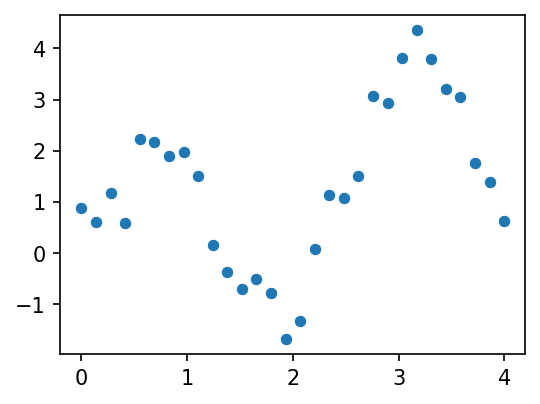

In [3]:
np.random.seed(11)
x = np.linspace(0,4,30)
y = 0.5*x + 2*np.sin(2.5*x) + 0.5*np.random.randn(x.shape[0])


fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = sns.scatterplot(x=x,y=y,ax=ax)

## Exercise 1

(a) Fit the above model using non-linear minimization with the initial guess $\boldsymbol{\theta} = [1,0.3,2,1.5]$. Plot the predictions from the fitted model over the domain [0,4] and comment on the fit.

(b) Compute the standard error of the parameters via bootstrap. Perform `r=500` bootstrap runs and set random number generation seed to 156. 

(c) Compute a 95% bootstrap confidence interval for $\theta_0$. Is it significant?


**Note:** 
1. For the plot in (a), generate predictions for linearly spaced points in [0,4]. These points can be generated using `np.linspace(0,4,100)`.
2. The first argument for the statistic function that your write has to be the data. There are multiple ways you can define this argument:
    1. List `[x,y]` or tuple `(x,y)`
    2. DataFrame `pd.DataFrame({'x':x,'y':y})`

In [4]:
def sine_model(x,theta):
    return theta[0] + theta[1]*x + theta[3]*np.sin(theta[2]*x)

def sse_model(theta,x,y):
    y_hat = sine_model(x,theta)
    return np.sum((y-y_hat)**2)

res_nlm = minimize(
    fun = sse_model,
    x0 = [1,0.3,2,1.5],
    args=(x,y),
)
theta_nlm = res_nlm.x
theta_nlm

array([-0.20958212,  0.60274236,  2.52467224,  2.05967246])

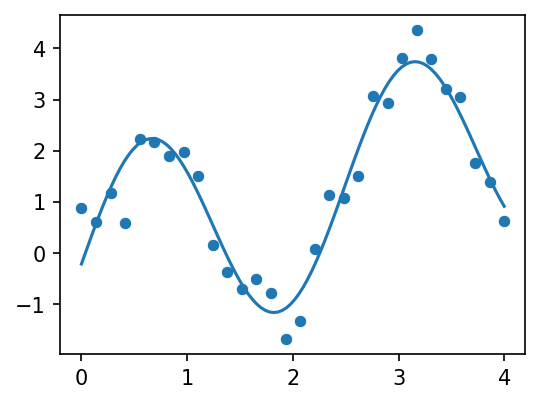

In [5]:
x_new = np.linspace(0,4,100)
y_pred_new = sine_model(x_new,theta_nlm)

fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = sns.scatterplot(x=x,y=y,ax=ax)
_ = sns.lineplot(x=x_new,y=y_pred_new,ax=ax)

In [6]:
dat = pd.DataFrame({'x':x,'y':y})

# statistic function
def sine_model_fit(data,idx,theta0):
    # sample coefficients
    data_idx = dat.iloc[idx,:]
    
    y = data_idx['y'].values
    x = data_idx['x'].values
    
    res = minimize(
        fun=sse_model,
        x0=theta0,
        args=(x,y)
    )
    
    return res.x

np.random.seed(156)
# run 500 bootstrap replicates
sine_boot = boot(dat,sine_model_fit,500,theta0=[1,0.3,2,1.5])
# covariance of parameters
cov_boot = np.cov(sine_boot['t'],rowvar=False)
# standard errors
se_boot = np.sqrt(np.diag(cov_boot))
se_boot

array([0.22043709, 0.09036953, 0.02240745, 0.13150949])

In [7]:
# Normal confidence interval
boot_ci(sine_boot,0,'norm',[0.95])

,lower,upper
conf,,
0.95,-0.641199,0.222034


## Exercise 2

- Using bootstrap, plot the histogram of the predictions at x = 2. Is the distribution normal?
- Compute a 95\% confidence interval on the prediction at x = 2.
- Compute a 95\% prediction interval on a future response at x = 2.

**Note**: If you are passing `x=2` to the model, the response will be scalar instead of a 1 element numpy array. Instead pass `x=np.array([2.])` 

In [8]:
y_pred = sine_model(np.array([2.]),sine_boot['t0'])
y_pred_reps = np.concatenate([sine_model(np.array([2.]),theta) for theta in sine_boot['t']])

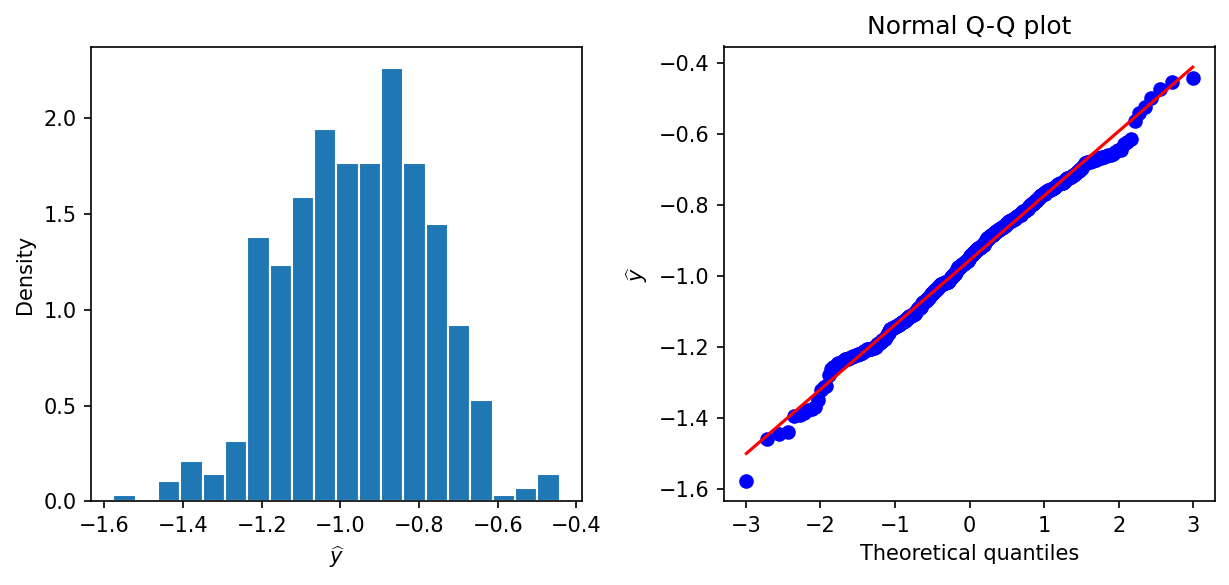

In [9]:
fig,axs = plt.subplots(1,2,figsize=(8.3,4))

label = r'$\widehat{y}$'

# First plot-histogram
_ = axs[0].hist(y_pred_reps,bins=20,density=True,edgecolor='w')
_ = axs[0].set_xlabel(label)
_ = axs[0].set_ylabel('Density')

# Second plot - QQ plot
_ =  probplot(y_pred_reps,plot=axs[1])
_ = axs[1].set_ylabel(label)
_ = axs[1].set_title('Normal Q-Q plot')

fig.tight_layout()

In [10]:
# confidence interval
se_y_pred = y_pred_reps.std() # estimate of standard error

alpha=0.05
ci_lower = y_pred + norm.ppf(alpha/2)*se_y_pred
ci_upper = y_pred + norm.ppf(1-alpha/2)*se_y_pred

# print them together
np.column_stack([ci_lower,ci_upper])

array([[-1.3033275 , -0.59256332]])

In [11]:
# first calculate MSE - estimate for error variance
n = x.shape[0] # number of samples
df_theta = len(res_nlm.x) # degrees of freedom for the parameters
mse = res_nlm.fun/(n-df_theta) # Mean squared error with correct degrees of freedom

# standard error for the response
se_y = np.sqrt(y_pred_reps.var() + mse)

pi_lower = y_pred + norm.ppf(alpha/2)*se_y
pi_upper = y_pred + norm.ppf(1-alpha/2)*se_y

# print them together
np.column_stack([pi_lower,pi_upper])

array([[-1.95989334,  0.06400252]])

## Exercise 3

Create a plot with the following elements

- (x,y) pairs from the data
- Model predictions for $x \in [0,4]$
- 95\% confidence intervals on the predictions for $x \in [0,4]$
- 95\% prediction intervals on future response for $x \in [0,4]$

We will be computing predictions on a uniformly spaced set of points between 0 and 4.

In [12]:
# 100 uniformly spaced set of points between 0 and 4
x_new = np.linspace(0,4,100)

In [13]:
# compute predictions of the model
y_pred = sine_model(x_new,sine_boot['t0'])

# compute bootstrap replicates of predictions
# each row corresponds to a bootstrap replicate
y_pred_boot = np.row_stack([
    sine_model(x_new,theta) for theta in sine_boot['t']
])

In [14]:
se_y_pred = y_pred_boot.std(axis=0)

# confidence intervals
ci_lower = y_pred + norm.ppf(alpha/2)*se_y_pred
ci_upper = y_pred + norm.ppf(1-alpha/2)*se_y_pred

In [15]:
se_y = np.sqrt(se_y_pred**2 + mse)

# prediction intervals
pi_lower = y_pred + norm.ppf(alpha/2)*se_y
pi_upper = y_pred + norm.ppf(1-alpha/2)*se_y

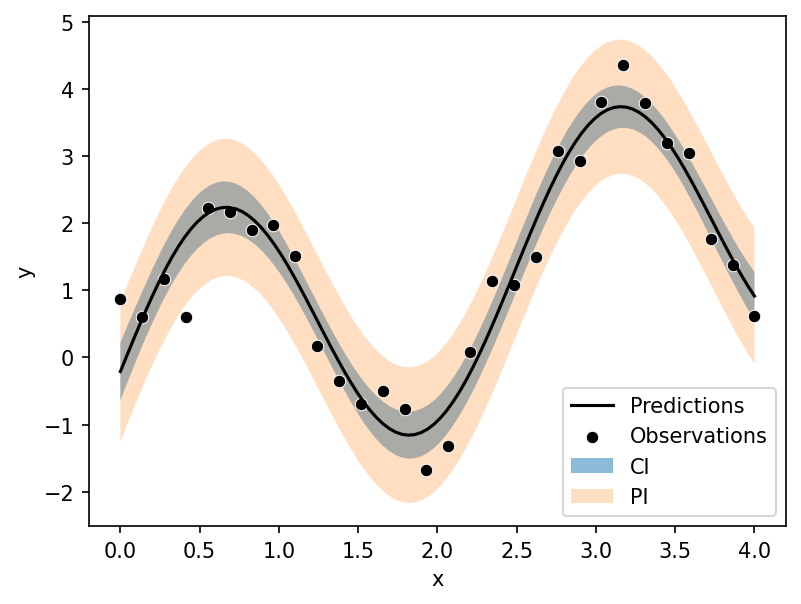

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
_ = sns.scatterplot(x=x,y=y,ax=ax,color='k',label='Observations',legend=False)
_ = sns.lineplot(x=x_new,y=y_pred,ax=ax,color='k',label='Predictions',legend=False)
# # shade between the lower and upper confidence bounds
_ = ax.fill_between(x_new,ci_lower,ci_upper,alpha=0.5,zorder=0,label='CI')
# # shade between the lower and upper prediction bounds
_ = ax.fill_between(x_new,pi_lower,pi_upper,alpha=0.25,zorder=0,label='PI')

_ = ax.set_xlabel('x')
_ = ax.set_ylabel('y')

_ = ax.legend(loc='lower right')